In [1]:
import xarray as xr
import numpy as np
from PIL import Image
import xesmf as xe
import netCDF4 as nc

In [ ]:
ds.sel(longitude=slice(70,150),latitude=slice(55,-11)).sum()

In [4]:
ds.sel(longitude=slice(65,100),latitude=slice(40,5)).sum()

<xarray.Dataset>
Dimensions:                                                                  ()
Data variables:
    Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes  float32 ...

# get lon and lat

In [2]:
# https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-count-rev11/data-download
ds = xr.open_dataset('population_all.nc')
lon = ds.sel(longitude=slice(65,100)).longitude
lat = ds.sel(latitude=slice(40,5)).latitude
lon = np.array(lon)
lat = np.array(lat)

In [6]:
out_bounds = {'lon': np.arange(65.05, 100.1, 0.1),
              'lat': np.arange(5.05, 40.1, 0.1),
              'lon_b': np.arange(65.05-0.1/2, 100.1+0.1/2, 0.1),
              'lat_b': np.arange(5.05-0.1/2, 40.1+0.1/2, 0.1),
             }

in_bounds = {'lon': np.arange(65, 100, 0.0417),
             'lat': np.arange(5, 40, 0.0417),
             'lon_b': np.arange(65-0.0417/2, 100+0.0417/2, 0.0417),
             'lat_b': np.arange(5-0.0417/2, 40+0.0417/2, 0.0417),
            }

regridder_conserve = xe.Regridder(in_bounds, out_bounds, method='conservative')

In [5]:
out_bounds['lon'].shape

(351,)

# get pop data

In [7]:
# Gridded Population of the World (GPW v4r10) database
years = [2000, 2005, 2010, 2015, 2020]
for year in years:
    im = Image.open(f'gpw_v4_population_count_rev11_{year}_2pt5_min.tif')
    im = np.array(im)
    im_india = im[1200:2040, 5880:6720]
    im_india[im_india < 0] = 0
    ds_india = xr.DataArray(im_india)
    ds_india = ds_india.reindex(dim_0=ds_india.dim_0[::-1])
    population = regridder_conserve(ds_india)
    population = population * ds_india.sum() / population.sum()
    ds_original = xr.Dataset({"population_count": (("lat", "lon"), ds_india)},
                        coords={"lat": lat, 
                                "lon": lon,
                                "year": year})
    ds_original.to_netcdf(f'pop_{year}.nc')
    ds_population = xr.Dataset({"population_count": (("lat", "lon"), population)},
                        coords={"lat": out_bounds['lat'][::-1], 
                                "lon": out_bounds['lon'],
                                "year": year})
    ds_population.to_netcdf(f'gridded_pop_{year}.nc')

/home/rlan/.conda/envs/gc/lib/python3.8/site-packages/xesmf/frontend.py:590: UserWarning: Using dimensions ('dim_0', 'dim_1') from data variable None as the horizontal dimensions for the regridding.
  warnings.warn(
/home/rlan/.conda/envs/gc/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/rlan/.conda/envs/gc/lib/python3.8/site-packages/xesmf/frontend.py:590: UserWarning: Using dimensions ('dim_0', 'dim_1') from data variable None as the horizontal dimensions for the regridding.
  warnings.warn(
/home/rlan/.conda/envs/gc/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/rlan/.conda/envs/gc/lib/python3.8/site-packages/xesmf/fr

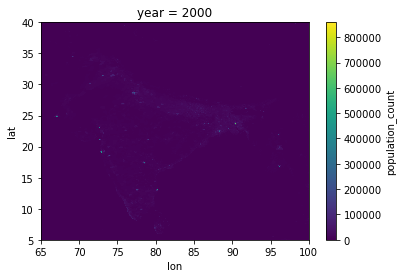

In [9]:
with xr.open_dataset('pop_2000.nc') as ds:
    ds.population_count.plot()

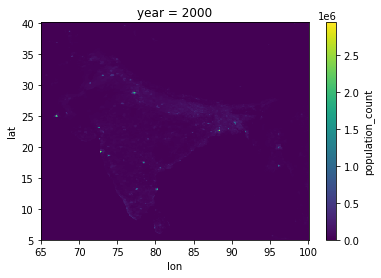

In [10]:
with xr.open_dataset('gridded_pop_2000.nc') as ds:
    ds.population_count.plot()

# make pop for other years

In [11]:
# world bank
pop_rate  = {1997:1.869172003,
             1998:1.839658764,
             1999:1.805559737,
             2000:1.76812551,
             2001:1.72876857,
             2002:1.689561661,
             2003:1.651491269,
             2004:1.615308295,
             2005:1.579709143,
             2006:1.545696439,
             2007:1.509221986,
             2008:1.464889915,
             2009:1.410582714,
             2010:1.350338314,
             2011:1.288512962,
             2012:1.231484894,
             2013:1.182904215,
             2014:1.145673402,
             2015:1.116895913,
             2016:1.090459321,
             2017:1.06335943,
             2018:1.037827848,
             2019:1.013261249,
             2020:0.93287307}

pop_year = {2000:1997, 2005:2001, 2010:2006, 2015: 2011, 2020: 2016}
def make_pop(input_year):
    ds = xr.open_dataset(f'gridded_pop_{input_year}.nc')
    year = input_year
    pop = ds.population_count
    while year > pop_year[input_year]:
        year = year - 1
        pop = pop / ((100+pop_rate[year]) / 100)
        ds_population = xr.Dataset({"population_count": (("lat", "lon"), pop)},
                            coords={"lat": out_bounds['lat'][::-1], 
                                    "lon": out_bounds['lon'],
                                    "year": year})
        ds_population.to_netcdf(f'gridded_pop_{year}.nc')
    ds.close()

In [12]:
years = range(2000, 2021, 5)
for year in years:
    make_pop(year)

# make avg pop

In [13]:
years = range(1997, 2020)
pop = []
for year in years:
    ds = xr.open_dataset(f'gridded_pop_{year}.nc').population_count
    pop.append(ds)
    ds.close()
pop = np.array(pop)

In [14]:
pop_mean = pop.mean(axis=0)
pop_mean = xr.DataArray(pop_mean)
ds_population = xr.Dataset({"population_count": (("lat", "lon"), pop_mean)},
                            coords={"lat": out_bounds['lat'][::-1], 
                                    "lon": out_bounds['lon'],
                                    "year": 'avg from 1997 to 2019'})
ds_population.to_netcdf(f'gridded_pop_avg.nc')

In [15]:
pop_mean.shape

(351, 351)